# Dependency Parser (Assignment)
Everything should be done ON MY code, no new code.


1. Read https://aclanthology.org/D14-1082.pdf and maybe just write one paragraph summary in your README.md in your github

2. Do something called ablation study (meaning try to delete something so we know the impact of that deleted thing - very common in NLP)
- Recall that we have 18 word + 18 pos + 12 dep features
- Try to delete only the 12 dep features and check UAS
- Try to delete only the 18 pos features and check UAS
3. Do another comparison study testing the embedding
Chaky uses some embedding
Try to use (1) glove embedding (smallest), (2) nn.Embedding (train from scratch) and compare with Chaky's embedding - on how it affects the UAS
4. Do some testing, compare 2-3 sentences with spaCy and see whether our neural network gives the same dependency.

Criteria:
0: not done
1: ok
2: with comments/explanation like how Chaky does his tutorial

## 1. Read https://aclanthology.org/D14-1082.pdf and maybe just write one paragraph summary in your README.md in your github
//Already created readme in my github

## 2. Do something called ablation study (meaning try to delete something so we know the impact of that deleted thing - very common in NLP)

### 2.1 Recall that we have 18 word + 18 pos + 12 dep features

In [1]:
import sys
import numpy as np
import time
import os
import logging
from collections import Counter
from datetime import datetime
import math

from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim

To make the dependency parser, there will be lot of component.

1. The transition parsing function
2. Loading the data (conll)
3. The actual parser
4. The embedding lookup
5. The deep learning model
6. The training and evaluation

Alert:  there will be a lot of coding today!

**Note**:  In real life (production), you probably just use the existing tool such as `spaCy` (which we will learn).  Here we just learn so we can develop a deep understanding.

### Parsing function

We gonna start with a class `Parsing`, representing a parser for each sentence.  For each sentence, we need the `stack`, `buffer`, and the `dependencies`.

In [2]:
class Parsing(object):
    def __init__(self, sentence):
        self.sentence = sentence #['The', 'cat', 'sat']
        
        # The current stack represented as a list with the top of the stack as the
        # last element of the list.
        self.stack = ['ROOT']
        
        # The current buffer represented as a list with the first item on the
        # buffer as the first item of the list
        self.buffer = sentence[:]
        
        # The list of dependencies produced so far. Represented as a list of
        # tuples where each tuple is of the form (head, dependent).
        self.dep = []
    
    #Let's first create a function to perform "Shift", "Left-Arc", and "Right-Arc"
    def parse_step(self, transition):
        if transition == 'S':
            buffer_head = self.buffer.pop(0)
            self.stack.append(buffer_head)
        #stack: [ROOT, I, parsed]
        elif transition == 'LA':
            dependent = self.stack.pop(-2) #I
            self.dep.append((self.stack[-1], dependent)) #(parsed, I)
        #stack: [ROOT, parsed, sentence]
        elif transition == 'RA':
            dependent = self.stack.pop() #sentence
            self.dep.append((self.stack[-1], dependent)) #(parsed, sentence)
        else:
            print(f"Unknown transition: {transition}")
            
    #loop all transitions
    def parse(self, transitions):
        for transition in transitions:
            self.parse_step(transition)
        return self.dep
    
    #an utility function to check that the parsing is done.
    def is_completed(self):
        return (len(self.buffer) == 0) and (len(self.stack) == 1)

#### Testing the parse step

In [3]:
parsing = Parsing(["The", "cat", "sat"])
parsing.stack, parsing.buffer, parsing.dep

(['ROOT'], ['The', 'cat', 'sat'], [])

In [4]:
#let's try shift
parsing.parse_step("S")
parsing.stack, parsing.buffer, parsing.dep

(['ROOT', 'The'], ['cat', 'sat'], [])

In [5]:
#let's try shift
parsing.parse_step("LA")
parsing.stack, parsing.buffer, parsing.dep

(['The'], ['cat', 'sat'], [('The', 'ROOT')])

In [6]:
#let's try shift
parsing.parse_step("S")
parsing.stack, parsing.buffer, parsing.dep

(['The', 'cat'], ['sat'], [('The', 'ROOT')])

In [7]:
#let's try shift
parsing.parse_step("RA")
parsing.stack, parsing.buffer, parsing.dep

(['The'], ['sat'], [('The', 'ROOT'), ('The', 'cat')])

#### Testing the parse

In [8]:
parsing = Parsing(["The", "cat", "sat"])
parsing.parse(["S", "LA", "S", "RA"])
parsing.stack, parsing.buffer, parsing.dep

(['The'], ['sat'], [('The', 'ROOT'), ('The', 'cat')])

#### Minibatch parsing

We gonna create a minibatch loader that loads a bunch of sentences, and perform parse accordingly.  For now, we will assume a very dump model to predict the transitions.

In [9]:
def minibatch_parse(sentences, model, batch_size):
    dep = []

    # Initialize a list of DepParser, one for each sentence.
    partial_parses = [Parsing(sentence) for sentence in sentences]
    
    # Shallow copy partial_parses.
    unfinished_parses = partial_parses[:]
        
    # While unfinished_parses is not empty do.
    while unfinished_parses:
        # Take first batch_size parses in unfinished_parses as minibatch.
        minibatch = unfinished_parses[:batch_size]
        # Use model to predict next transition for each partial parse in the minibatch.
        transitions = model.predict(minibatch)
        # Perform parse step for each partial_parse_minibatch with their predicted transition.
        for transition, partial_parse in zip(transitions, minibatch):
            partial_parse.parse_step(transition)
        # Remove completed parses.
        unfinished_parses[:] = [
            p for p in unfinished_parses if not p.is_completed()]
    dep = [parse.dep for parse in partial_parses]

    return dep

In [10]:
class DummyModel(object):
    """
    Dummy model for testing the minibatch_parse function
    First shifts everything onto the stack and then does exclusively right arcs if the first word of
    the sentence is "right", "left" if otherwise.
    """

    def predict(self, partial_parses):
        return [("RA" if pp.stack[1] == "right" else "LA") if len(pp.buffer) == 0 else "S"
                for pp in partial_parses]

#### Testing the minibatch

In [11]:
sentences = [["right", "arcs", "only"],
             ["right", "arcs", "only", "again"],
             ["left", "arcs", "only"],
             ["left", "arcs", "only", "again"]]
deps = minibatch_parse(sentences, DummyModel(), 2)

In [12]:
deps

[[('arcs', 'only'), ('right', 'arcs'), ('ROOT', 'right')],
 [('only', 'again'), ('arcs', 'only'), ('right', 'arcs'), ('ROOT', 'right')],
 [('only', 'arcs'), ('only', 'left'), ('only', 'ROOT')],
 [('again', 'only'), ('again', 'arcs'), ('again', 'left'), ('again', 'ROOT')]]

### Load data

We used English Penn Treebank dataset in CoNLL format.

CoNLL is the conventional name for TSV formats in NLP (TSV - tab-separated values, i.e., CSV with <TAB> as separator).
It originates from a series of shared tasks organized at the Conferences of Natural Language Learning (hence the name)

In CoNLL formats,
- every word (token) is represented in one line
- every sentence is separated from the next by an empty line
- every column represents one annotation

There are many formats, in our case, our conll file has 10 columns, the important columns are:
- 1:  word
- 4:  pos
- 6:  head of the dependency
- 7:  type of dependency

In [13]:
#define the config for easy management
class Config(object):
    data_path = ''
    train_file = 'train.conll'
    dev_file = 'dev.conll'
    test_file = 'test.conll'
    embedding_file = 'en-cw.txt'

In [14]:
#function for reading the conll file
def read_conll(filename, max_example=5):
    examples = []
    with open(filename) as f:
        i = 0
        word, pos, head, dep = [], [], [], []
        for line in f.readlines():
            i = i + 1
            wa = line.strip().split('\t') #wa = word annotations
            
            #if all 10 columns are there....
            if len(wa) == 10:  
                word.append(wa[1].lower())
                pos.append(wa[4])
                head.append(int(wa[6]))
                dep.append(wa[7])
            
            #otherwise, it means the line is empty, thus we consider finish for one example
            elif len(word) > 0:
                examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})
                word, pos, head, dep = [], [], [], []
                    
        #last example
        if len(word) > 0:
            examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})
            
    return examples

#### Testing the load function

In [15]:
import time

#sample_size = (train, dev, test)
def load_data(sample_size=(1000, 500, 500)):
    config = Config()

    print("1. Loading data...",)
    start = time.time()
    train_set = read_conll(os.path.join(config.data_path, config.train_file))
    dev_set   = read_conll(os.path.join(config.data_path, config.dev_file))
    test_set  = read_conll(os.path.join(config.data_path, config.test_file))

    #for shorter preprocessing time.....just for education, ok guys?
    train_set = train_set[:sample_size[0]]
    dev_set   = dev_set[:sample_size[1]]
    test_set  = test_set[:sample_size[2]]
    print("Example 1: ", train_set[1]) #i choose one because it's short

    print("took {:.2f} seconds".format(time.time() - start))
    
    return train_set, dev_set, test_set

#### Testing the preprocessing data...

In [16]:
print(80 * "=")
print("INITIALIZING")
print(80 * "=")
train_set, dev_set, test_set = load_data()

INITIALIZING
1. Loading data...
Example 1:  {'word': ['ms.', 'haag', 'plays', 'elianti', '.'], 'pos': ['NNP', 'NNP', 'VBZ', 'NNP', '.'], 'head': [2, 3, 0, 3, 3], 'dep': ['compound', 'nsubj', 'root', 'dobj', 'punct']}
took 3.00 seconds


To understand, we can draw these in a dependency tree, with the help of spaCy.  **Note** that spaCy do not draw the ROOT for us, but imagine the head of "plays" is ROOT.

In [17]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Ms. Haag plays Elianti .")
options = {"collapse_punct": False}
displacy.render(doc, options = options, style="dep", jupyter=True)

for token in doc:
    print(token.dep_)

compound
nsubj
ROOT
dobj
punct


### Parser

We gonna create a parser that gonna help us:
- create a `tok2id` dictionary in the `__init__` function
- numercalize `numercalize` the words, dependencies, and pos tags
- create training data, `create_instances` by leveraging the ground truth of the dependencies
- finally the `parse` function

This feature vector consists of a list of tokens. They can be represented as a list of integers $\mathbf{w} = [w_1, w_2, \cdots, w_m]$ where $m$ is the number of features and each $0 \leq w_i \leq |V|$ is the index of a token in the vocabulary ($|V|$ is the vocabulary size).  Then our network looks up an embedding for each word and concatenates them into a single input vector:

$$\mathbf{x} = [\mathbf{E}_{w_1}, \cdots, \mathbf{E}_{w_m}] \in \mathbb{R}^{dm}$$

where $\mathbf{E} \in \mathbb{R}^{|V| \times d}$ is an embedding matrix with each row $\mathbf{E}_w$ as the vector for a particular word $w$

#### Features

A total of 18 + 18 + 12 features were used in the paper.

- Feature 1: 18 features
  - (a). 6 - top 3 words on buffer, top 3 words on stack, 
  - (b). 6 - the first and second left most/rightmost children and the leftmost/rightmost of the **top word** (i.e., `stack[-1]`) on the stack,  - `(leftmost(0), rightmost(0), secondleftmost(0), secondrightmost(0), leftmost(leftmost(0)), rightmost(rightmost(0)))`
  - (c). 6 - the first and second left most/rightmost children and the leftmost/rightmost of the **second top word** (i.e., `stack[-2]`) on the stack, - `(leftmost(0), rightmost(0), secondleftmost(0), secondrightmost(0), leftmost(leftmost(0)), rightmost(rightmost(0)))`
- Feature 2: 18 pos - basically corresponding POS tags
- Feature 3: 12 dep - corresponding ARC, excluding 6 words on the stack/buffer..

**NOTE**: There is no 3a because each word itself does not have dependency

**NOTE**: For brevity, the table skipped 2b, 2c

**NOTE**: Here, in the dependency column, I used LABELED dependency.   But in my code, it is unlabeled, thus e.g., COMPOUND will not be needed.

| Stack | Buffer | Feature 1a | Feature 1b | Feature 1c | Feature 2a | Feature 3b | Feature 3c | Dependency (ARC) | Transition |
| :--   |  :--   | :--        | :--        | :--        | :--        | :--        | :--        | :--               | :--        |
| [ROOT] | [Ms., Haag, plays, Elianti, .] | [NULL, NULL, ROOT, Ms., Haag, plays] | [NULL, NULL, NULL, NULL, NULL, NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-NULL, P-NULL, P-ROOT, PROPN, PROPN, VERB] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]  | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]| | Init |
| [ROOT, Ms.] | [Haag, plays, Elianti, .] | [NULL, ROOT, Ms., Haag, plays, Elianti] | [NULL, NULL, NULL, NULL, NULL, NULL]  | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-NULL, P-ROOT, PROPN, PROPN, VERB, PROPN] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]  | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]| | SHIFT |
| [ROOT, Ms., Haag] | [plays, Elianti, .] | [ROOT, Ms., Haag, plays, Elianti, .] | [NULL, NULL, NULL, NULL, NULL, NULL]  | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-ROOT, PROPN, PROPN, VERB, PROPN, PUNCT] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]  | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]|  | SHIFT |
| [ROOT, Haag] | [plays, Elianti, .] | [NULL, ROOT, Haag, plays, Elianti, .] | [Ms., NULL, NULL, NULL, NULL, NULL, NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-NULL, P-ROOT, PROPN, VERB, PROPN, PUNCT] | [COMPOUND, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | (Haag, Ms., COMPOUND) | LEFTARC |
| [ROOT, Haag, plays] | [Elianti, .] | [ROOT, Haag, plays, Elianti, ., NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [Ms., NULL, NULL, NULL, NULL, NULL] | [P-ROOT, PROPN, VERB, PROPN, PUNCT, P-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | [COMPOUND, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | (Haag, Ms., COMPOUND) | SHIFT |
| [ROOT, plays] | [Elianti, .] | [NULL, ROOT, plays, Elianti, ., NULL] | [Haag, NULL, NULL, NULL, Ms., NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-NULL, P-ROOT, VERB, PROPN, PUNCT, P-NULL] | [NSUBJ, D-NULL, D-NULL, D-NULL, COMPOUND, D-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ) | LEFTARC |
| [ROOT, plays, Elianti] | [.] | [ROOT, plays, Elianti, ., NULL, NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [Haag, NULL, NULL, NULL, Ms., NULL] | [P-ROOT, VERB, PROPN, PUNCT, P-NULL, P-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | [NSUBJ, D-NULL, D-NULL, D-NULL, COMPOUND, D-NULL] | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ) | SHIFT |
| [ROOT, plays] | [.] | [NULL, ROOT, plays, ., NULL, NULL] | [Haag, Elianti, NULL, NULL, Ms., NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-NULL, P-ROOT, VERB, PUNCT, P-NULL, P-NULL] | [NSUBJ, DOBJ, D-NULL, D-NULL, COMPOUND, D-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ), (plays, Elianti, DOBJ) | RIGHTARC |
| [ROOT, plays, .] | [] | [ROOT, plays, ., NULL, NULL, NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [Haag, Elianti, NULL, NULL, Ms., NULL] | [P-NULL, P-ROOT, VERB, PUNCT, P-NULL, P-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | [NSUBJ, DOBJ, D-NULL, D-NULL, COMPOUND, D-NULL] | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ), (plays, Elianti, DOBJ) | SHIFT |
| [ROOT, plays] | [] | [NULL, ROOT, plays, NULL, NULL, NULL] | [Haag, Elianti, NULL, plays, Ms., NULL] | [Haag, Elianti, NULL, NULL, Ms., NULL] | [P-NULL, P-ROOT, VERB, P-NULL, P-NULL, P-NULL] | [NSUBJ, PUNCT, D-NULL, DOBJ, COMPOUND, D-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ), (plays, Elianti, DOBJ), (plays, ., PUNCT) | RIGHT-ARC |
| [ROOT] | [] |  | |  |  |  |  | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ), (plays, Elianti, DOBJ), (plays, ., PUNCT), (ROOT, plays, ROOT) | RIGHT-ARC |

In [18]:
P_PREFIX = '<p>:' #indicating pos tags
D_PREFIX = '<d>:' #indicating dependency tags
UNK      = '<UNK>'
NULL     = '<NULL>'
ROOT     = '<ROOT>'

class Parser(object):

    def __init__(self, dataset):
        
        #set the root dep
        self.root_dep = 'root'
                
        #get all the dep of the dataset as list, e.g., ['root', 'acl', 'nmod', 'nmod:npmod']
        all_dep = [self.root_dep] + list(set([w for ex in dataset
                                               for w in ex['dep']
                                               if w != self.root_dep]))
        
        #1. put dep into tok2id lookup table, with D_PREFIX so we know it is dependency
        #{'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'D_PREFIX:<NULL>': 30}
        tok2id = {D_PREFIX + l: i for (i, l) in enumerate(all_dep)}
        tok2id[D_PREFIX + NULL] = self.D_NULL = len(tok2id)
        
        #we are using "unlabeled" where we do not label with the dependency
        #thus the number of dependency relation is 1
        trans = ['L', 'R', 'S']
        self.n_deprel = 1
        
        #create a simple lookup table mapping action and id
        #e.g., tran2id: {'L': 0, 'R': 1, 'S': 2}
        #e.g., id2tran: {0: 'L', 1: 'R', 2: 'S'}
        self.n_trans = len(trans)
        self.tran2id = {t: i for (i, t) in enumerate(trans)}
        self.id2tran = {i: t for (i, t) in enumerate(trans)}

        #2. put pos tags into tok2id lookup table, with P_PREFIX so we know it is pos
        tok2id.update(build_dict([P_PREFIX + w for ex in dataset for w in ex['pos']],
                                  offset=len(tok2id)))
        tok2id[P_PREFIX + UNK]  = self.P_UNK  = len(tok2id)  #also remember the pos tags of unknown
        tok2id[P_PREFIX + NULL] = self.P_NULL = len(tok2id)
        tok2id[P_PREFIX + ROOT] = self.P_ROOT = len(tok2id)
        
        #now tok2id:  {'P_PREFIX:root': 0, 'P_PREFIX:acl': 1, ..., 'P_PREFIX:JJR': 62, 'P_PREFIX:<UNK>': 63, 'P_PREFIX:<NULL>': 64, 'P_PREFIX:<ROOT>': 65}
        
        #3. put word into tok2id lookup table
        tok2id.update(build_dict([w for ex in dataset for w in ex['word']],
                                  offset=len(tok2id)))
        tok2id[UNK]  = self.UNK = len(tok2id)
        tok2id[NULL] = self.NULL = len(tok2id)
        tok2id[ROOT] = self.ROOT = len(tok2id)
        
        #now tok2id: {'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'memory': 340, 'mr.': 341, '<UNK>': 342, '<NULL>': 343, '<ROOT>': 344}
        
        #create id2tok
        self.tok2id = tok2id
        self.id2tok = {v: k for (k, v) in tok2id.items()}
        
        #why 18 normal features + 18 (pos) + 12 (dep)
        #18 features - top 3 words on buffer, top 3 words on stack, 
        # the first and second left most/rightmost children of the top two words on the stack
        # the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack
        #18 pos - basically corresponding POS tags
        #12 dep - corresponding ARC, excluding 6 words on hte stack/buffer..
        self.n_features = 18 + 18 + 12
        self.n_tokens = len(tok2id)
    
    #function to turn train set with words to train set with id instead using tok2id
    def numericalize(self, examples):
        numer_examples = []
        for ex in examples:
            word = [self.ROOT] + [self.tok2id[w] if w in self.tok2id
                                  else self.UNK for w in ex['word']]
            pos  = [self.P_ROOT] + [self.tok2id[P_PREFIX + w] if P_PREFIX + w in self.tok2id
                                   else self.P_UNK for w in ex['pos']]
            head = [-1] + ex['head']
            dep  = [-1] + [self.tok2id[D_PREFIX + w] if D_PREFIX + w in self.tok2id
                            else -1 for w in ex['dep']]
            numer_examples.append({'word': word, 'pos': pos,
                                 'head': head, 'dep': dep})
        return numer_examples

    #function to extract features to form a feature embedding matrix
    def extract_features(self, stack, buf, arcs, ex):
             
        #ex['word']:  [55, 32, 33, 34, 35, 30], i.e., ['root', 'ms.', 'haag', 'plays', 'elianti', '.']
        #ex['pos']:   [29, 14, 14, 16, 14, 17], i.e., ['NNP', 'NNP', 'VBZ', 'NNP', '.']
        #ex['head']:  [-1, 2, 3, 0, 3, 3]  or ['root', 'compound', 'nsubj', 'root', 'dobj', 'punct']}
        #ex['dep']:   [-1, 1, 2, 0, 6, 12] or ['compound', 'nsubj', 'root', 'dobj', 'punct']

        #stack     :  [0]
        #buffer    :  [1, 2, 3, 4, 5]
        
        if stack[0] == "ROOT":
            stack[0] = 0  #start the stack with [ROOT]

        #get leftmost children based on the dependency arcs
        def get_lc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] < k])

        #get right most children based on the dependency arcs
        def get_rc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] > k],
                          reverse=True)

        p_features = [] #pos features (2a, 2b, 2c) - 18
        d_features = [] #dep features (3b, 3c) - 12
        
        #last 3 things on the stack as features
        #if the stack is less than 3, then we simply append NULL from the left
        features = [self.NULL] * (3 - len(stack)) + [ex['word'][x] for x in stack[-3:]]
        
        # next 3 things on the buffer as features
        #if the buffer is less than 3, simply append NULL
        #the reason why NULL is appended on end because buffer is read left to right
        features += [ex['word'][x] for x in buf[:3]] + [self.NULL] * (3 - len(buf))
        
        #corresponding pos tags
        p_features = [self.P_NULL] * (3 - len(stack)) + [ex['pos'][x] for x in stack[-3:]]
        p_features += [ex['pos'][x] for x in buf[:3]] + [self.P_NULL] * (3 - len(buf))
        
        #get the leftmost and rightmost children of the top two words, thus we loop 2 times
        for i in range(2):
            if i < len(stack):
                k = stack[-i-1] #-1, -2 last two in the stack
                
                #the first and second lefmost/rightmost children of the top two words (i=1, 2) on the stack
                lc = get_lc(k)  
                rc = get_rc(k)
                
                #the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack:
                llc = get_lc(lc[0]) if len(lc) > 0 else []
                rrc = get_rc(rc[0]) if len(rc) > 0 else []

                #(leftmost of first word on stack, rightmost of first word, 
                # leftmost of the second word on stack, rightmost of second, 
                # leftmost of leftmost, rightmost of rightmost
                features.append(ex['word'][lc[0]] if len(lc) > 0 else self.NULL)
                features.append(ex['word'][rc[0]] if len(rc) > 0 else self.NULL)
                features.append(ex['word'][lc[1]] if len(lc) > 1 else self.NULL)
                features.append(ex['word'][rc[1]] if len(rc) > 1 else self.NULL)
                features.append(ex['word'][llc[0]] if len(llc) > 0 else self.NULL)
                features.append(ex['word'][rrc[0]] if len(rrc) > 0 else self.NULL)

                #corresponding pos
                p_features.append(ex['pos'][lc[0]] if len(lc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rc[0]] if len(rc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][lc[1]] if len(lc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][rc[1]] if len(rc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][llc[0]] if len(llc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rrc[0]] if len(rrc) > 0 else self.P_NULL)
            
                #corresponding dep
                d_features.append(ex['dep'][lc[0]] if len(lc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rc[0]] if len(rc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][lc[1]] if len(lc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][rc[1]] if len(rc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][llc[0]] if len(llc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rrc[0]] if len(rrc) > 0 else self.D_NULL)
                
            else:
                #attach NULL when they don't exist
                features += [self.NULL] * 6
                p_features += [self.P_NULL] * 6
                d_features += [self.D_NULL] * 6

        features += p_features + d_features
        assert len(features) == self.n_features  #assert they are 18 + 18 + 12
        return features

    #decide whether to shift, leftarc, or rightarc, based on gold parse trees
    #this is needed to create training examples which contain samples and ground truth
    def get_oracle(self, stack, buf, ex):

        #leave if the stack is only 1, thus nothing to predict....
        if len(stack) < 2:
            return self.n_trans - 1

        #predict based on the last two words on the stack
        i0 = stack[-1]
        i1 = stack[-2]

        #get the head and dependency
        h0 = ex['head'][i0]
        h1 = ex['head'][i1]
        d0 = ex['dep'][i0]
        d1 = ex['dep'][i1]

        #either shift, left arc or right arc
        #"Shift" = 2; "LA" = 0; "RA" = 1
        #if head of the second last word is the last word, then leftarc
        if (i1 > 0) and (h1 == i0):
            return 0
        #if head of the last word is the second last word, then rightarc
        #make sure nothing in the buffer has head with the last word on the stack
        #otherwise, we lose the last word.....
        elif (i1 >= 0) and (h0 == i1) and \
                (not any([x for x in buf if ex['head'][x] == i0])):
            return 1
        #otherwise shift, if something is left in buffer, otherwise, do nothing....
        else:
            return None if len(buf) == 0 else 2

    #generate training examples
    #from the training sentences and their gold parse trees 
    def create_instances(self, examples):
        all_instances = []
        
        for i, ex in enumerate(examples):
            #e.g., ex['word]: [344, 163, 99, 164, 165, 68]
            n_words = len(ex['word']) - 1  #excluding the root

            #arcs = {(head, tail, dependency label)}
            stack = [0]
            buf = [i + 1 for i in range(n_words)]  #[1, 2, 3, 4, 5]
            arcs = []
            instances = []
            
            #because that's the maximum number of shift, leftarcs, rightarcs you can have
            #this will determine the sample size of each training example
            #if given five words, we will get a sample of (10, 48) where 10 comes from 5 * 2, and 48 is n_features
            #but this for loop can be break if there is nothing left....
            for i in range(n_words * 2):

                #get the gold transition based on the parse trees
                #gold_t can be either shift(2), leftarc(0), or rightarc(1)
                gold_t = self.get_oracle(stack, buf, ex)
                
                #if gold_t is None, no need to extract features.....
                if gold_t is None:
                    break
                
                #make sure when the model predicts, we inform the current state of stack and buffer, so
                #the model is not allowed to make any illegal action, e.g., buffer is empty but trying to pop
                legal_labels = self.legal_labels(stack, buf)                
                assert legal_labels[gold_t] == 1
               
                #extract all the 48 features 
                features = self.extract_features(stack, buf, arcs, ex)
                instances.append((features, legal_labels, gold_t))
            
                #shift 
                if gold_t == 2:
                    stack.append(buf[0])
                    buf = buf[1:]
                #left arc 
                elif gold_t == 0:
                    arcs.append((stack[-1], stack[-2], gold_t))
                    stack = stack[:-2] + [stack[-1]]
                #right arc
                else:
                    arcs.append((stack[-2], stack[-1], gold_t - self.n_deprel))
                    stack = stack[:-1]
            else:
                all_instances += instances

        return all_instances

    #provide an one hot encoding of the labels
    def legal_labels(self, stack, buf):
        labels =  ([1] if len(stack) > 2  else [0]) * self.n_deprel   #left arc   But cannot ROOT <----He thus 3
        labels += ([1] if len(stack) >= 2 else [0]) * self.n_deprel   #right arc  ROOT--->He
        labels += [1] if len(buf) > 0 else [0]   #shift
        return labels
    
    #a simple function to check punctuation POS tags
    def punct(self, pos):
        return pos in ["''", ",", ".", ":", "``", "-LRB-", "-RRB-"]

    def parse(self, dataset, eval_batch_size=5000):
        sentences = []
        sentence_id_to_idx = {}
                
        for i, example in enumerate(dataset):
            
            #example['word']=[188, 186, 186, ..., 59]
            #n_words=37
            #sentence=[1, 2, 3, 4, 5,.., 37]
                        
            n_words = len(example['word']) - 1
            sentence = [j + 1 for j in range(n_words)]            
            sentences.append(sentence)
            
            #mapping the object unique id to the i            
            #The id is the object's memory address
            sentence_id_to_idx[id(sentence)] = i
            
        model = ModelWrapper(self, dataset, sentence_id_to_idx)
        dependencies = minibatch_parse(sentences, model, eval_batch_size)
                
        UAS = all_tokens = 0.0
        with tqdm(total=len(dataset)) as prog:
            for i, ex in enumerate(dataset):
                head = [-1] * len(ex['word'])
                for h, t, in dependencies[i]:
                    head[t] = h
                for pred_h, gold_h, gold_l, pos in \
                        zip(head[1:], ex['head'][1:], ex['dep'][1:], ex['pos'][1:]):
                        assert self.id2tok[pos].startswith(P_PREFIX)
                        pos_str = self.id2tok[pos][len(P_PREFIX):]
                        if (not self.punct(pos_str)):
                            UAS += 1 if pred_h == gold_h else 0
                            all_tokens += 1
                prog.update(i + 1)
        UAS /= all_tokens
        return UAS, dependencies

In [19]:
class ModelWrapper(object):
    def __init__(self, parser, dataset, sentence_id_to_idx):
        self.parser = parser
        self.dataset = dataset
        self.sentence_id_to_idx = sentence_id_to_idx

    def predict(self, partial_parses):
        mb_x = [self.parser.extract_features(p.stack, p.buffer, p.dep,
                                             self.dataset[self.sentence_id_to_idx[id(p.sentence)]])
                for p in partial_parses]
        mb_x = np.array(mb_x).astype('int32')
        mb_x = torch.from_numpy(mb_x).long()
        mb_l = [self.parser.legal_labels(p.stack, p.buffer) for p in partial_parses]

        pred = self.parser.model(mb_x)
        pred = pred.detach().numpy()
        
        #we need to multiply 10000 with legal labels, to force the model not to make any impossible prediction
        #other, when we parse sequentially, sometimes there is nothing in the buffer or stack, thus error....        
        pred = np.argmax(pred + 10000 * np.array(mb_l).astype('float32'), 1)
        pred = ["S" if p == 2 else ("LA" if p == 0 else "RA") for p in pred]
        
        return pred

In [20]:
#a simple function to create ids.....
def build_dict(keys, offset=0):
    #keys = ['P_PREFIX:IN', 'P_PREFIX:DT', 'P_PREFIX:NNP', 'P_PREFIX:CD', so on...]
    #offset is needed because this tok2id has something already inside....
    count = Counter()
    for key in keys:
        count[key] += 1
    
    #most_common = [('P_PREFIX:NN', 70), ('P_PREFIX:IN', 57), ... , ('P_PREFIX:JJR', 1)]
    #we use most_common in case we only want some maximum pos tags....
    mc = count.most_common()
    
    #{'P_PREFIX:NN': 31, 'P_PREFIX:IN': 32, .., 'P_PREFIX:JJR': 62} 
    return {w[0]: index + offset for (index, w) in enumerate(mc)}

#### Testing the parser `__init__`

In [21]:
print("2. Building parser...",)
start = time.time()
parser = Parser(train_set)
print("took {:.2f} seconds".format(time.time() - start))

2. Building parser...
took 0.03 seconds


#### Testing the `numericalize`

In [22]:
#before numericalize
print("Word: ",  train_set[1]['word'])
print("Pos:  ",  train_set[1]['pos'])
print("Head: ",  train_set[1]['head'])
print("Dep:  ",  train_set[1]['dep'])

Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:   ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]
Dep:   ['compound', 'nsubj', 'root', 'dobj', 'punct']


In [23]:
print("3. Numericalizing data...",)
start = time.time()
train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)
print("took {:.2f} seconds".format(time.time() - start))

3. Numericalizing data...
took 0.07 seconds


In [24]:
#after numericalize (rootis added in front)
train_set[1]['word']

[5156, 304, 1364, 1002, 2144, 87]

In [25]:
for i in train_set[1]['word']:
    print(parser.id2tok[i])

<ROOT>
ms.
haag
plays
elianti
.


In [26]:
#after numericalize (pos tag root is added in front)
train_set[1]['pos']

[84, 42, 42, 55, 42, 46]

In [27]:
for i in train_set[1]['pos']:
    print(parser.id2tok[i])

<p>:<ROOT>
<p>:NNP
<p>:NNP
<p>:VBZ
<p>:NNP
<p>:.


In [28]:
#after numericalize (root has no head, so we assign -1)
train_set[1]['head']

[-1, 2, 3, 0, 3, 3]

In [29]:
#after numericalize (root has no dep, so we assign -1)
train_set[1]['dep']

[-1, 25, 12, 0, 28, 9]

### Word Embedding

Word embedding length of 50.  In the paper, they applied a custom 50-embedding to all the words, pos, and dependencies.  For pos and dependencies, they claimed that there are some similarities that can be learned as well.

In [30]:
print("4. Loading pretrained embeddings...",)
config = Config()
start = time.time()
word_vectors = {}
for line in open(config.embedding_file).readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 2.69 seconds


### Preprocessing

In [31]:
print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

5. Preprocessing training data...
took 1.85 seconds


### Minibatch loader

In [32]:
def get_minibatches(data, minibatch_size, shuffle=True):
    data_size = len(data[0])
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    for minibatch_start in np.arange(0, data_size, minibatch_size):
        minibatch_indices = indices[minibatch_start:minibatch_start + minibatch_size]
        yield [_minibatch(d, minibatch_indices) for d in data]

def _minibatch(data, minibatch_idx):
    return data[minibatch_idx] if type(data) is np.ndarray else [data[i] for i in minibatch_idx]

def minibatches(data, batch_size):
    x = np.array([d[0] for d in data])
    y = np.array([d[2] for d in data])
    one_hot = np.zeros((y.size, 3))
    one_hot[np.arange(y.size), y] = 1
    return get_minibatches([x, one_hot], batch_size)

#### Testing your minibatch loader

In [33]:
# for i, (train_x, train_y) in enumerate(minibatches(train_examples, 1024)):
#     print(train_x.shape)  #batch size, features
#     print(train_y.shape)        #one hot encoding of 3 actions - shift, la, ra

### Neural Network

Let's train a neural network to predict, given the state of the stack, buffer, and dependencies, which transition should be applied next.

Recall that our input vector is:

$$\mathbf{x} = [\mathbf{E}_{w_1}, \cdots, \mathbf{E}_{w_m}] \in \mathbb{R}^{dm}$$

where $\mathbf{E} \in \mathbb{R}^{|V| \times d}$ is an embedding matrix with each row $\mathbf{E}_w$ as the vector for a particular word $w$

We then compute our prediction as:

$$\mathbf{h} = \text{ReLU}(\mathbf{xW} + \mathbf{b}_1)$$
$$\mathbf{l} = \mathbf{hU} + \mathbf{b}_2$$
$$\hat{\mathbf{y}} = \text{softmax}(l)$$

where $\mathbf{h}$ is referred to as the hidden layer, $\mathbf{l}$ is the logits, $\hat{\mathbf{y}}$ is the predictions, and $\text{ReLU}(z) = \text{max}(z, 0))$.  We will then train the model to minimize cross-entropy (CE) loss:

$$J(\theta) = \text{CE}(\mathbf{y}, \hat{\mathbf{y}}) = -\sum_{i=1}^{3}y_i \log \hat{y}_i$$

To compute the loss for the training set, we average this $J(\theta)$ across all training examples.  We will use UAS (Unlabeled Attachment Score) as main metric, which is computed as the ratio between number of correctly predicted dependencies and the number of total dependencies despite of the relations (which our model doesn't predict the relation since is unlabeled). 

In [34]:
class ParserModel(nn.Module):

    def __init__(self, embeddings, n_features=48,
                 hidden_size=400, n_classes=3, dropout_prob=0.5):

        super(ParserModel, self).__init__()
        self.n_features   = n_features
        self.n_classes    = n_classes
        self.dropout_prob = dropout_prob
        self.embed_size   = embeddings.shape[1]
        self.hidden_size  = hidden_size
        self.pretrained_embeddings = nn.Embedding(embeddings.shape[0], self.embed_size)
        self.pretrained_embeddings.weight = nn.Parameter(torch.tensor(embeddings))

        self.embed_to_hidden = nn.Linear(n_features * self.embed_size, hidden_size)
        nn.init.xavier_uniform_(self.embed_to_hidden.weight, gain=1.)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.hidden_to_logits = nn.Linear(hidden_size, n_classes)
        nn.init.xavier_uniform_(self.hidden_to_logits.weight)

    def embedding_lookup(self, t):
        #t:  batch_size, n_features
        batch_size = t.size()[0]
                    
        x = self.pretrained_embeddings(t)        
        x = x.reshape(-1, self.n_features * self.embed_size)
        # x = (1024, 48 * 50)

        return x

    def forward(self, t):
        # t: (1024, 48)
        embeddings = self.embedding_lookup(t)  
    
        # embeddings: (1024, 48 * 50)
        hidden = self.embed_to_hidden(embeddings)
    
        # hidden: (1024, 200)
        hidden_activations = F.relu(hidden)
        # hidden_activations: (1024, 200)
        thin_net = self.dropout(hidden_activations)
        # thin_net: (1024, 200)
        logits = self.hidden_to_logits(thin_net)
        # logits: (1024, 3)

        return logits

Now complete the <code>train_for_epoch</code> and <code>train</code> functions to actually train the model.

In [35]:
#just a class to get the average.....
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [36]:
def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005):
    
    best_dev_UAS = 0
    
    optimizer = optim.Adam(parser.model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(
            parser, train_data, dev_data, optimizer, loss_func, batch_size)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size):
    
    parser.model.train()  # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()

    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size)):
            
            #train_x:  batch_size, n_features
            #train_y:  batch_size, target(=3)
            
            optimizer.zero_grad() 
            loss = 0.
            train_x = torch.from_numpy(train_x).long()  #long() for int so embedding works....
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()  #get the index with 1 because torch expects label to be single integer

            # Forward pass: compute predicted logits.
            logits = parser.model(train_x)
            # Compute loss
            loss = loss_func(logits, train_y)
            # Compute gradients of the loss w.r.t model parameters.
            loss.backward()
            # Take step with optimizer.
            optimizer.step()

            prog.update(1)
            loss_meter.update(loss.item())

    print("Average Train Loss: {}".format(loss_meter.avg))
    print("Evaluating on dev set",)
    parser.model.eval()  # Places model in "eval" mode, i.e. don't apply dropout layer
        
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

### Training

In [37]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 24.66it/s]


Average Train Loss: 0.8773038300375143
Evaluating on dev set


125250it [00:00, 6686393.65it/s]       


- dev UAS: 53.49
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 24.50it/s]


Average Train Loss: 0.34603272813061875
Evaluating on dev set


125250it [00:00, 6559082.27it/s]       


- dev UAS: 62.65
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.02it/s]


Average Train Loss: 0.2739281163861354
Evaluating on dev set


125250it [00:00, 6622167.86it/s]       


- dev UAS: 65.09
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.09it/s]


Average Train Loss: 0.23824124100307623
Evaluating on dev set


125250it [00:00, 6585145.61it/s]       


- dev UAS: 68.17
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.12it/s]


Average Train Loss: 0.2107957989598314
Evaluating on dev set


125250it [00:00, 6734393.60it/s]       


- dev UAS: 70.84
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.38it/s]


Average Train Loss: 0.18975919050474963
Evaluating on dev set


125250it [00:00, 6413348.02it/s]       


- dev UAS: 71.59
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.13it/s]


Average Train Loss: 0.172836784273386
Evaluating on dev set


125250it [00:00, 6702174.91it/s]       


- dev UAS: 71.74
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.93it/s]


Average Train Loss: 0.1532217807446917
Evaluating on dev set


125250it [00:00, 6498312.46it/s]       


- dev UAS: 73.29
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.91it/s]


Average Train Loss: 0.14028875467677912
Evaluating on dev set


125250it [00:00, 6461783.98it/s]       


- dev UAS: 74.82
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.05it/s]


Average Train Loss: 0.13193910320599875
Evaluating on dev set


125250it [00:00, 6692697.23it/s]       

- dev UAS: 75.48
New best dev UAS! Saving model.



### Testing

In [38]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 6741307.05it/s]       

- test UAS: 76.46
Done!


### 2.2 Try to delete only the 12 dep features and check UAS

### Parser

In [39]:
P_PREFIX = '<p>:' #indicating pos tags
D_PREFIX = '<d>:' #indicating dependency tags
UNK      = '<UNK>'
NULL     = '<NULL>'
ROOT     = '<ROOT>'

class Parser(object):

    def __init__(self, dataset):
        
        #set the root dep
        self.root_dep = 'root'
                
        #get all the dep of the dataset as list, e.g., ['root', 'acl', 'nmod', 'nmod:npmod']
        all_dep = [self.root_dep] + list(set([w for ex in dataset for w in ex['dep'] if w != self.root_dep]))
        
        #1. put dep into tok2id lookup table, with D_PREFIX so we know it is dependency
        #{'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'D_PREFIX:<NULL>': 30}
        tok2id = {D_PREFIX + l: i for (i, l) in enumerate(all_dep)}
        tok2id[D_PREFIX + NULL] = self.D_NULL = len(tok2id)
        
        #we are using "unlabeled" where we do not label with the dependency
        #thus the number of dependency relation is 1
        trans = ['L', 'R', 'S']
        self.n_deprel = 1
        
        #create a simple lookup table mapping action and id
        #e.g., tran2id: {'L': 0, 'R': 1, 'S': 2}
        #e.g., id2tran: {0: 'L', 1: 'R', 2: 'S'}
        self.n_trans = len(trans)
        self.tran2id = {t: i for (i, t) in enumerate(trans)}
        self.id2tran = {i: t for (i, t) in enumerate(trans)}

        #2. put pos tags into tok2id lookup table, with P_PREFIX so we know it is pos
        tok2id.update(build_dict([P_PREFIX + w for ex in dataset for w in ex['pos']],
                                  offset=len(tok2id)))
        tok2id[P_PREFIX + UNK]  = self.P_UNK  = len(tok2id)  #also remember the pos tags of unknown
        tok2id[P_PREFIX + NULL] = self.P_NULL = len(tok2id)
        tok2id[P_PREFIX + ROOT] = self.P_ROOT = len(tok2id)
        
        #now tok2id:  {'P_PREFIX:root': 0, 'P_PREFIX:acl': 1, ..., 'P_PREFIX:JJR': 62, 'P_PREFIX:<UNK>': 63, 'P_PREFIX:<NULL>': 64, 'P_PREFIX:<ROOT>': 65}
        
        #3. put word into tok2id lookup table
        tok2id.update(build_dict([w for ex in dataset for w in ex['word']],
                                  offset=len(tok2id)))
        tok2id[UNK]  = self.UNK = len(tok2id)
        tok2id[NULL] = self.NULL = len(tok2id)
        tok2id[ROOT] = self.ROOT = len(tok2id)
        
        #now tok2id: {'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'memory': 340, 'mr.': 341, '<UNK>': 342, '<NULL>': 343, '<ROOT>': 344}
        
        #create id2tok
        self.tok2id = tok2id
        self.id2tok = {v: k for (k, v) in tok2id.items()}
        
        #why 18 normal features + 18 (pos) + 12 (dep)
        #18 features - top 3 words on buffer, top 3 words on stack, 
        # the first and second left most/rightmost children of the top two words on the stack
        # the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack
        #18 pos - basically corresponding POS tags
        #12 dep - corresponding ARC, excluding 6 words on hte stack/buffer..
        self.n_features = 18 + 18
        self.n_tokens = len(tok2id)
    
    #function to turn train set with words to train set with id instead using tok2id
    def numericalize(self, examples):
        numer_examples = []
        for ex in examples:
            word = [self.ROOT] + [self.tok2id[w] if w in self.tok2id
                                  else self.UNK for w in ex['word']]
            pos  = [self.P_ROOT] + [self.tok2id[P_PREFIX + w] if P_PREFIX + w in self.tok2id
                                   else self.P_UNK for w in ex['pos']]
            head = [-1] + ex['head']
            numer_examples.append({'word': word, 'pos': pos,
                                 'head': head})
        return numer_examples

    #function to extract features to form a feature embedding matrix
    def extract_features(self, stack, buf, arcs, ex):
             
        #ex['word']:  [55, 32, 33, 34, 35, 30], i.e., ['root', 'ms.', 'haag', 'plays', 'elianti', '.']
        #ex['pos']:   [29, 14, 14, 16, 14, 17], i.e., ['NNP', 'NNP', 'VBZ', 'NNP', '.']
        #ex['head']:  [-1, 2, 3, 0, 3, 3]  or ['root', 'compound', 'nsubj', 'root', 'dobj', 'punct']}
        #ex['dep']:   [-1, 1, 2, 0, 6, 12] or ['compound', 'nsubj', 'root', 'dobj', 'punct']

        #stack     :  [0]
        #buffer    :  [1, 2, 3, 4, 5]
        
        if stack[0] == "ROOT":
            stack[0] = 0  #start the stack with [ROOT]

        #get leftmost children based on the dependency arcs
        def get_lc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] < k])

        #get right most children based on the dependency arcs
        def get_rc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] > k],
                          reverse=True)

        p_features = [] #pos features (2a, 2b, 2c) - 18
        d_features = [] #dep features (3b, 3c) - 12
        
        #last 3 things on the stack as features
        #if the stack is less than 3, then we simply append NULL from the left
        features = [self.NULL] * (3 - len(stack)) + [ex['word'][x] for x in stack[-3:]]
        
        # next 3 things on the buffer as features
        #if the buffer is less than 3, simply append NULL
        #the reason why NULL is appended on end because buffer is read left to right
        features += [ex['word'][x] for x in buf[:3]] + [self.NULL] * (3 - len(buf))
        
        #corresponding pos tags
        p_features = [self.P_NULL] * (3 - len(stack)) + [ex['pos'][x] for x in stack[-3:]]
        p_features += [ex['pos'][x] for x in buf[:3]] + [self.P_NULL] * (3 - len(buf))
        
        #get the leftmost and rightmost children of the top two words, thus we loop 2 times
        for i in range(2):
            if i < len(stack):
                k = stack[-i-1] #-1, -2 last two in the stack
                
                #the first and second lefmost/rightmost children of the top two words (i=1, 2) on the stack
                lc = get_lc(k)  
                rc = get_rc(k)
                
                #the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack:
                llc = get_lc(lc[0]) if len(lc) > 0 else []
                rrc = get_rc(rc[0]) if len(rc) > 0 else []

                #(leftmost of first word on stack, rightmost of first word, 
                # leftmost of the second word on stack, rightmost of second, 
                # leftmost of leftmost, rightmost of rightmost
                features.append(ex['word'][lc[0]] if len(lc) > 0 else self.NULL)
                features.append(ex['word'][rc[0]] if len(rc) > 0 else self.NULL)
                features.append(ex['word'][lc[1]] if len(lc) > 1 else self.NULL)
                features.append(ex['word'][rc[1]] if len(rc) > 1 else self.NULL)
                features.append(ex['word'][llc[0]] if len(llc) > 0 else self.NULL)
                features.append(ex['word'][rrc[0]] if len(rrc) > 0 else self.NULL)

                #corresponding pos
                p_features.append(ex['pos'][lc[0]] if len(lc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rc[0]] if len(rc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][lc[1]] if len(lc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][rc[1]] if len(rc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][llc[0]] if len(llc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rrc[0]] if len(rrc) > 0 else self.P_NULL)
                
            else:
                #attach NULL when they don't exist
                features += [self.NULL] * 6
                p_features += [self.P_NULL] * 6

        features += p_features
        assert len(features) == self.n_features  #assert they are 18 + 18
        return features

    #decide whether to shift, leftarc, or rightarc, based on gold parse trees
    #this is needed to create training examples which contain samples and ground truth
    def get_oracle(self, stack, buf, ex):

        #leave if the stack is only 1, thus nothing to predict....
        if len(stack) < 2:
            return self.n_trans - 1

        #predict based on the last two words on the stack
        i0 = stack[-1]
        i1 = stack[-2]

        #get the head and dependency
        h0 = ex['head'][i0]
        h1 = ex['head'][i1]

        #either shift, left arc or right arc
        #"Shift" = 2; "LA" = 0; "RA" = 1
        #if head of the second last word is the last word, then leftarc
        if (i1 > 0) and (h1 == i0):
            return 0
        #if head of the last word is the second last word, then rightarc
        #make sure nothing in the buffer has head with the last word on the stack
        #otherwise, we lose the last word.....
        elif (i1 >= 0) and (h0 == i1) and \
                (not any([x for x in buf if ex['head'][x] == i0])):
            return 1
        #otherwise shift, if something is left in buffer, otherwise, do nothing....
        else:
            return None if len(buf) == 0 else 2

    #generate training examples
    #from the training sentences and their gold parse trees 
    def create_instances(self, examples):
        all_instances = []
        
        for i, ex in enumerate(examples):
            #e.g., ex['word]: [344, 163, 99, 164, 165, 68]
            n_words = len(ex['word']) - 1  #excluding the root

            #arcs = {(head, tail, dependency label)}
            stack = [0]
            buf = [i + 1 for i in range(n_words)]  #[1, 2, 3, 4, 5]
            arcs = []
            instances = []
            
            #because that's the maximum number of shift, leftarcs, rightarcs you can have
            #this will determine the sample size of each training example
            #if given five words, we will get a sample of (10, 48) where 10 comes from 5 * 2, and 48 is n_features
            #but this for loop can be break if there is nothing left....
            for i in range(n_words * 2):

                #get the gold transition based on the parse trees
                #gold_t can be either shift(2), leftarc(0), or rightarc(1)
                gold_t = self.get_oracle(stack, buf, ex)
                
                #if gold_t is None, no need to extract features.....
                if gold_t is None:
                    break
                
                #make sure when the model predicts, we inform the current state of stack and buffer, so
                #the model is not allowed to make any illegal action, e.g., buffer is empty but trying to pop
                legal_labels = self.legal_labels(stack, buf)                
                assert legal_labels[gold_t] == 1
               
                #extract all the 48 features 
                features = self.extract_features(stack, buf, arcs, ex)
                instances.append((features, legal_labels, gold_t))
            
                #shift 
                if gold_t == 2:
                    stack.append(buf[0])
                    buf = buf[1:]
                #left arc 
                elif gold_t == 0:
                    arcs.append((stack[-1], stack[-2], gold_t))
                    stack = stack[:-2] + [stack[-1]]
                #right arc
                else:
                    arcs.append((stack[-2], stack[-1], gold_t - self.n_deprel))
                    stack = stack[:-1]
            else:
                all_instances += instances

        return all_instances

    #provide an one hot encoding of the labels
    def legal_labels(self, stack, buf):
        labels =  ([1] if len(stack) > 2  else [0]) * self.n_deprel   #left arc   But cannot ROOT <----He thus 3
        labels += ([1] if len(stack) >= 2 else [0]) * self.n_deprel   #right arc  ROOT--->He
        labels += [1] if len(buf) > 0 else [0]   #shift
        return labels
    
    #a simple function to check punctuation POS tags
    def punct(self, pos):
        return pos in ["''", ",", ".", ":", "``", "-LRB-", "-RRB-"]

    def parse(self, dataset, eval_batch_size=5000):
        sentences = []
        sentence_id_to_idx = {}
                
        for i, example in enumerate(dataset):
            
            #example['word']=[188, 186, 186, ..., 59]
            #n_words=37
            #sentence=[1, 2, 3, 4, 5,.., 37]
                        
            n_words = len(example['word']) - 1
            sentence = [j + 1 for j in range(n_words)]            
            sentences.append(sentence)
            
            #mapping the object unique id to the i            
            #The id is the object's memory address
            sentence_id_to_idx[id(sentence)] = i
            
        model = ModelWrapper(self, dataset, sentence_id_to_idx)
        dependencies = minibatch_parse(sentences, model, eval_batch_size)
                
        UAS = all_tokens = 0.0
        with tqdm(total=len(dataset)) as prog:
            for i, ex in enumerate(dataset):
                head = [-1] * len(ex['word'])
                for h, t, in dependencies[i]:
                    head[t] = h
                for pred_h, gold_h, pos in \
                        zip(head[1:], ex['head'][1:], ex['pos'][1:]):
                        assert self.id2tok[pos].startswith(P_PREFIX)
                        pos_str = self.id2tok[pos][len(P_PREFIX):]
                        if (not self.punct(pos_str)):
                            UAS += 1 if pred_h == gold_h else 0
                            all_tokens += 1
                prog.update(i + 1)
        UAS /= all_tokens
        return UAS, dependencies

In [40]:
class ModelWrapper(object):
    def __init__(self, parser, dataset, sentence_id_to_idx):
        self.parser = parser
        self.dataset = dataset
        self.sentence_id_to_idx = sentence_id_to_idx

    def predict(self, partial_parses):
        mb_x = [self.parser.extract_features(p.stack, p.buffer, p.dep,
                                             self.dataset[self.sentence_id_to_idx[id(p.sentence)]])
                for p in partial_parses]
        mb_x = np.array(mb_x).astype('int32')
        mb_x = torch.from_numpy(mb_x).long()
        mb_l = [self.parser.legal_labels(p.stack, p.buffer) for p in partial_parses]

        pred = self.parser.model(mb_x)
        pred = pred.detach().numpy()
        
        #we need to multiply 10000 with legal labels, to force the model not to make any impossible prediction
        #other, when we parse sequentially, sometimes there is nothing in the buffer or stack, thus error....        
        pred = np.argmax(pred + 10000 * np.array(mb_l).astype('float32'), 1)
        pred = ["S" if p == 2 else ("LA" if p == 0 else "RA") for p in pred]
        
        return pred

In [41]:
#a simple function to create ids.....
def build_dict(keys, offset=0):
    #keys = ['P_PREFIX:IN', 'P_PREFIX:DT', 'P_PREFIX:NNP', 'P_PREFIX:CD', so on...]
    #offset is needed because this tok2id has something already inside....
    count = Counter()
    for key in keys:
        count[key] += 1
    
    #most_common = [('P_PREFIX:NN', 70), ('P_PREFIX:IN', 57), ... , ('P_PREFIX:JJR', 1)]
    #we use most_common in case we only want some maximum pos tags....
    mc = count.most_common()
    
    #{'P_PREFIX:NN': 31, 'P_PREFIX:IN': 32, .., 'P_PREFIX:JJR': 62} 
    return {w[0]: index + offset for (index, w) in enumerate(mc)}

In [42]:
class ParserModel(nn.Module):

    def __init__(self, embeddings, n_features=36,
                 hidden_size=400, n_classes=3, dropout_prob=0.5):

        super(ParserModel, self).__init__()
        self.n_features   = n_features
        self.n_classes    = n_classes
        self.dropout_prob = dropout_prob
        self.embed_size   = embeddings.shape[1]
        self.hidden_size  = hidden_size
        self.pretrained_embeddings = nn.Embedding(embeddings.shape[0], self.embed_size)
        self.pretrained_embeddings.weight = nn.Parameter(torch.tensor(embeddings))

        self.embed_to_hidden = nn.Linear(n_features * self.embed_size, hidden_size)
        nn.init.xavier_uniform_(self.embed_to_hidden.weight, gain=1.)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.hidden_to_logits = nn.Linear(hidden_size, n_classes)
        nn.init.xavier_uniform_(self.hidden_to_logits.weight)

    def embedding_lookup(self, t):
        #t:  batch_size, n_features
        batch_size = t.size()[0]
                    
        x = self.pretrained_embeddings(t)        
        x = x.reshape(-1, self.n_features * self.embed_size)
        # x = (1024, 48 * 50)

        return x

    def forward(self, t):
        # t: (1024, 48)
        embeddings = self.embedding_lookup(t)  
    
        # embeddings: (1024, 48 * 50)
        hidden = self.embed_to_hidden(embeddings)
    
        # hidden: (1024, 200)
        hidden_activations = F.relu(hidden)
        # hidden_activations: (1024, 200)
        thin_net = self.dropout(hidden_activations)
        # thin_net: (1024, 200)
        logits = self.hidden_to_logits(thin_net)
        # logits: (1024, 3)

        return logits

#### Testing the parser `__init__`

In [43]:
print(80 * "=")
print("INITIALIZING")
print(80 * "=")
train_set, dev_set, test_set = load_data()

INITIALIZING
1. Loading data...
Example 1:  {'word': ['ms.', 'haag', 'plays', 'elianti', '.'], 'pos': ['NNP', 'NNP', 'VBZ', 'NNP', '.'], 'head': [2, 3, 0, 3, 3], 'dep': ['compound', 'nsubj', 'root', 'dobj', 'punct']}
took 2.62 seconds


In [44]:
print("2. Building parser...",)
start = time.time()
parser = Parser(train_set)
print("took {:.2f} seconds".format(time.time() - start))

2. Building parser...
took 0.03 seconds


#### Testing the `numericalize`

In [45]:
#before numericalize
print("Word: ",  train_set[1]['word'])
print("Pos:  ",  train_set[1]['pos'])
print("Head: ",  train_set[1]['head'])
# print("Dep:  ",  train_set[1]['dep'])

Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:   ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]


In [46]:
print("3. Numericalizing data...",)
start = time.time()
train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)
print("took {:.2f} seconds".format(time.time() - start))

3. Numericalizing data...
took 0.05 seconds


In [47]:
#after numericalize (rootis added in front)
train_set[1]['word']

[5156, 304, 1364, 1002, 2144, 87]

In [48]:
for i in train_set[1]['word']:
    print(parser.id2tok[i])

<ROOT>
ms.
haag
plays
elianti
.


In [49]:
#after numericalize (pos tag root is added in front)
train_set[1]['pos']

[84, 42, 42, 55, 42, 46]

In [50]:
for i in train_set[1]['pos']:
    print(parser.id2tok[i])

<p>:<ROOT>
<p>:NNP
<p>:NNP
<p>:VBZ
<p>:NNP
<p>:.


In [51]:
#after numericalize (root has no head, so we assign -1)
train_set[1]['head']

[-1, 2, 3, 0, 3, 3]

### Word Embedding

Word embedding length of 50.  In the paper, they applied a custom 50-embedding to all the words, pos, and dependencies.  For pos and dependencies, they claimed that there are some similarities that can be learned as well.

In [52]:
print("4. Loading pretrained embeddings...",)
config = Config()
start = time.time()
word_vectors = {}
for line in open(config.embedding_file).readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 2.47 seconds


### Preprocessing

In [53]:
print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

5. Preprocessing training data...
took 1.62 seconds


### Minibatch loader

In [54]:
def get_minibatches(data, minibatch_size, shuffle=True):
    data_size = len(data[0])
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    for minibatch_start in np.arange(0, data_size, minibatch_size):
        minibatch_indices = indices[minibatch_start:minibatch_start + minibatch_size]
        yield [_minibatch(d, minibatch_indices) for d in data]

def _minibatch(data, minibatch_idx):
    return data[minibatch_idx] if type(data) is np.ndarray else [data[i] for i in minibatch_idx]

def minibatches(data, batch_size):
    x = np.array([d[0] for d in data])
    y = np.array([d[2] for d in data])
    one_hot = np.zeros((y.size, 3))
    one_hot[np.arange(y.size), y] = 1
    return get_minibatches([x, one_hot], batch_size)

#### Testing your minibatch loader

In [55]:
# for i, (train_x, train_y) in enumerate(minibatches(train_examples, 1024)):
#     print(train_x.shape)  #batch size, features
#     print(train_y.shape)        #one hot encoding of 3 actions - shift, la, ra

In [56]:
def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005):
    
    best_dev_UAS = 0
    
    optimizer = optim.Adam(parser.model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(
            parser, train_data, dev_data, optimizer, loss_func, batch_size)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size):
    
    parser.model.train()  # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()
    
    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size)):
            
            #train_x:  batch_size, n_features
            #train_y:  batch_size, target(=3)
            optimizer.zero_grad() 
            loss = 0.
            train_x = torch.from_numpy(train_x).long()  #long() for int so embedding works....
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()  #get the index with 1 because torch expects label to be single integer

            # Forward pass: compute predicted logits.
            logits = parser.model(train_x)
            # Compute loss
            # print(logits.shape, train_y.shape, )
            loss = loss_func(logits, train_y)
            # Compute gradients of the loss w.r.t model parameters.
            loss.backward()
            # Take step with optimizer.
            optimizer.step()

            prog.update(1)
            loss_meter.update(loss.item())

    print("Average Train Loss: {}".format(loss_meter.avg))
    print("Evaluating on dev set",)
    parser.model.eval()  # Places model in "eval" mode, i.e. don't apply dropout layer
        
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

### Training

In [57]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.97it/s]


Average Train Loss: 0.5276538319885731
Evaluating on dev set


125250it [00:00, 6605514.60it/s]       


- dev UAS: 60.54
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.66it/s]


Average Train Loss: 0.27448750132073957
Evaluating on dev set


125250it [00:00, 6867144.78it/s]       


- dev UAS: 66.16
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.72it/s]


Average Train Loss: 0.21784652241816124
Evaluating on dev set


125250it [00:00, 6828938.44it/s]       


- dev UAS: 69.61
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.84it/s]


Average Train Loss: 0.18455509934574366
Evaluating on dev set


125250it [00:00, 6916600.74it/s]       


- dev UAS: 72.05
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.24it/s]


Average Train Loss: 0.1582772887001435
Evaluating on dev set


125250it [00:00, 6702345.93it/s]       


- dev UAS: 73.96
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.31it/s]


Average Train Loss: 0.14128117387493452
Evaluating on dev set


125250it [00:00, 6888575.91it/s]       


- dev UAS: 75.14
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.89it/s]


Average Train Loss: 0.12391945455844204
Evaluating on dev set


125250it [00:00, 6846917.29it/s]       


- dev UAS: 76.52
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.61it/s]


Average Train Loss: 0.11013054832195242
Evaluating on dev set


125250it [00:00, 6857016.12it/s]       


- dev UAS: 75.16

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.99it/s]


Average Train Loss: 0.10083270414421956
Evaluating on dev set


125250it [00:00, 6880906.60it/s]       


- dev UAS: 76.03

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.11it/s]


Average Train Loss: 0.08860842961197098
Evaluating on dev set


125250it [00:00, 6901154.39it/s]       

- dev UAS: 77.53
New best dev UAS! Saving model.



### Testing

In [58]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 6868940.59it/s]       

- test UAS: 79.23
Done!


### 2.3 Try to delete only the 18 pos features and check UAS

In [59]:
P_PREFIX = '<p>:' #indicating pos tags
D_PREFIX = '<d>:' #indicating dependency tags
UNK      = '<UNK>'
NULL     = '<NULL>'
ROOT     = '<ROOT>'

class Parser(object):

    def __init__(self, dataset):
        
        #set the root dep
        self.root_dep = 'root'
                
        #get all the dep of the dataset as list, e.g., ['root', 'acl', 'nmod', 'nmod:npmod']
        all_dep = [self.root_dep] + list(set([w for ex in dataset
                                               for w in ex['dep']
                                               if w != self.root_dep]))
        
        #1. put dep into tok2id lookup table, with D_PREFIX so we know it is dependency
        #{'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'D_PREFIX:<NULL>': 30}
        tok2id = {D_PREFIX + l: i for (i, l) in enumerate(all_dep)}
        tok2id[D_PREFIX + NULL] = self.D_NULL = len(tok2id)
        
        #we are using "unlabeled" where we do not label with the dependency
        #thus the number of dependency relation is 1
        trans = ['L', 'R', 'S']
        self.n_deprel = 1
        
        #create a simple lookup table mapping action and id
        #e.g., tran2id: {'L': 0, 'R': 1, 'S': 2}
        #e.g., id2tran: {0: 'L', 1: 'R', 2: 'S'}
        self.n_trans = len(trans)
        self.tran2id = {t: i for (i, t) in enumerate(trans)}
        self.id2tran = {i: t for (i, t) in enumerate(trans)}

        #2. put pos tags into tok2id lookup table, with P_PREFIX so we know it is pos
        tok2id.update(build_dict([P_PREFIX + w for ex in dataset for w in ex['pos']],
                                  offset=len(tok2id)))
        tok2id[P_PREFIX + UNK]  = self.P_UNK  = len(tok2id)  #also remember the pos tags of unknown
        tok2id[P_PREFIX + NULL] = self.P_NULL = len(tok2id)
        tok2id[P_PREFIX + ROOT] = self.P_ROOT = len(tok2id)
        
        #now tok2id:  {'P_PREFIX:root': 0, 'P_PREFIX:acl': 1, ..., 'P_PREFIX:JJR': 62, 'P_PREFIX:<UNK>': 63, 'P_PREFIX:<NULL>': 64, 'P_PREFIX:<ROOT>': 65}
        
        #3. put word into tok2id lookup table
        tok2id.update(build_dict([w for ex in dataset for w in ex['word']],
                                  offset=len(tok2id)))
        tok2id[UNK]  = self.UNK = len(tok2id)
        tok2id[NULL] = self.NULL = len(tok2id)
        tok2id[ROOT] = self.ROOT = len(tok2id)
        
        #now tok2id: {'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'memory': 340, 'mr.': 341, '<UNK>': 342, '<NULL>': 343, '<ROOT>': 344}
        
        #create id2tok
        self.tok2id = tok2id
        self.id2tok = {v: k for (k, v) in tok2id.items()}
        
        #why 18 normal features + 18 (pos) + 12 (dep)
        #18 features - top 3 words on buffer, top 3 words on stack, 
        # the first and second left most/rightmost children of the top two words on the stack
        # the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack
        #18 pos - basically corresponding POS tags
        #12 dep - corresponding ARC, excluding 6 words on hte stack/buffer..
        self.n_features = 18 + 12
        self.n_tokens = len(tok2id)
    
    #function to turn train set with words to train set with id instead using tok2id
    def numericalize(self, examples):
        numer_examples = []
        for ex in examples:
            word = [self.ROOT] + [self.tok2id[w] if w in self.tok2id
                                  else self.UNK for w in ex['word']]
            head = [-1] + ex['head']
            dep  = [-1] + [self.tok2id[D_PREFIX + w] if D_PREFIX + w in self.tok2id
                            else -1 for w in ex['dep']]
            numer_examples.append({'word': word,
                                 'head': head, 'dep': dep})
        return numer_examples

    #function to extract features to form a feature embedding matrix
    def extract_features(self, stack, buf, arcs, ex):
             
        #ex['word']:  [55, 32, 33, 34, 35, 30], i.e., ['root', 'ms.', 'haag', 'plays', 'elianti', '.']
        #ex['pos']:   [29, 14, 14, 16, 14, 17], i.e., ['NNP', 'NNP', 'VBZ', 'NNP', '.']
        #ex['head']:  [-1, 2, 3, 0, 3, 3]  or ['root', 'compound', 'nsubj', 'root', 'dobj', 'punct']}
        #ex['dep']:   [-1, 1, 2, 0, 6, 12] or ['compound', 'nsubj', 'root', 'dobj', 'punct']

        #stack     :  [0]
        #buffer    :  [1, 2, 3, 4, 5]
        
        if stack[0] == "ROOT":
            stack[0] = 0  #start the stack with [ROOT]

        #get leftmost children based on the dependency arcs
        def get_lc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] < k])

        #get right most children based on the dependency arcs
        def get_rc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] > k],
                          reverse=True)

        p_features = [] #pos features (2a, 2b, 2c) - 18
        d_features = [] #dep features (3b, 3c) - 12
        
        #last 3 things on the stack as features
        #if the stack is less than 3, then we simply append NULL from the left
        features = [self.NULL] * (3 - len(stack)) + [ex['word'][x] for x in stack[-3:]]
        
        # next 3 things on the buffer as features
        #if the buffer is less than 3, simply append NULL
        #the reason why NULL is appended on end because buffer is read left to right
        features += [ex['word'][x] for x in buf[:3]] + [self.NULL] * (3 - len(buf))
        
        #get the leftmost and rightmost children of the top two words, thus we loop 2 times
        for i in range(2):
            if i < len(stack):
                k = stack[-i-1] #-1, -2 last two in the stack
                
                #the first and second lefmost/rightmost children of the top two words (i=1, 2) on the stack
                lc = get_lc(k)  
                rc = get_rc(k)
                
                #the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack:
                llc = get_lc(lc[0]) if len(lc) > 0 else []
                rrc = get_rc(rc[0]) if len(rc) > 0 else []

                #(leftmost of first word on stack, rightmost of first word, 
                # leftmost of the second word on stack, rightmost of second, 
                # leftmost of leftmost, rightmost of rightmost
                features.append(ex['word'][lc[0]] if len(lc) > 0 else self.NULL)
                features.append(ex['word'][rc[0]] if len(rc) > 0 else self.NULL)
                features.append(ex['word'][lc[1]] if len(lc) > 1 else self.NULL)
                features.append(ex['word'][rc[1]] if len(rc) > 1 else self.NULL)
                features.append(ex['word'][llc[0]] if len(llc) > 0 else self.NULL)
                features.append(ex['word'][rrc[0]] if len(rrc) > 0 else self.NULL)
            
                #corresponding dep
                d_features.append(ex['dep'][lc[0]] if len(lc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rc[0]] if len(rc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][lc[1]] if len(lc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][rc[1]] if len(rc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][llc[0]] if len(llc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rrc[0]] if len(rrc) > 0 else self.D_NULL)
                
            else:
                #attach NULL when they don't exist
                features += [self.NULL] * 6
                p_features += [self.P_NULL] * 6
                d_features += [self.D_NULL] * 6

        features += d_features
        assert len(features) == self.n_features  #assert they are 18 + 18 + 12
        return features

    #decide whether to shift, leftarc, or rightarc, based on gold parse trees
    #this is needed to create training examples which contain samples and ground truth
    def get_oracle(self, stack, buf, ex):

        #leave if the stack is only 1, thus nothing to predict....
        if len(stack) < 2:
            return self.n_trans - 1

        #predict based on the last two words on the stack
        i0 = stack[-1]
        i1 = stack[-2]

        #get the head and dependency
        h0 = ex['head'][i0]
        h1 = ex['head'][i1]
        d0 = ex['dep'][i0]
        d1 = ex['dep'][i1]

        #either shift, left arc or right arc
        #"Shift" = 2; "LA" = 0; "RA" = 1
        #if head of the second last word is the last word, then leftarc
        if (i1 > 0) and (h1 == i0):
            return 0
        #if head of the last word is the second last word, then rightarc
        #make sure nothing in the buffer has head with the last word on the stack
        #otherwise, we lose the last word.....
        elif (i1 >= 0) and (h0 == i1) and \
                (not any([x for x in buf if ex['head'][x] == i0])):
            return 1
        #otherwise shift, if something is left in buffer, otherwise, do nothing....
        else:
            return None if len(buf) == 0 else 2

    #generate training examples
    #from the training sentences and their gold parse trees 
    def create_instances(self, examples):
        all_instances = []
        
        for i, ex in enumerate(examples):
            #e.g., ex['word]: [344, 163, 99, 164, 165, 68]
            n_words = len(ex['word']) - 1  #excluding the root

            #arcs = {(head, tail, dependency label)}
            stack = [0]
            buf = [i + 1 for i in range(n_words)]  #[1, 2, 3, 4, 5]
            arcs = []
            instances = []
            
            #because that's the maximum number of shift, leftarcs, rightarcs you can have
            #this will determine the sample size of each training example
            #if given five words, we will get a sample of (10, 48) where 10 comes from 5 * 2, and 48 is n_features
            #but this for loop can be break if there is nothing left....
            for i in range(n_words * 2):

                #get the gold transition based on the parse trees
                #gold_t can be either shift(2), leftarc(0), or rightarc(1)
                gold_t = self.get_oracle(stack, buf, ex)
                
                #if gold_t is None, no need to extract features.....
                if gold_t is None:
                    break
                
                #make sure when the model predicts, we inform the current state of stack and buffer, so
                #the model is not allowed to make any illegal action, e.g., buffer is empty but trying to pop
                legal_labels = self.legal_labels(stack, buf)                
                assert legal_labels[gold_t] == 1
               
                #extract all the 48 features 
                features = self.extract_features(stack, buf, arcs, ex)
                instances.append((features, legal_labels, gold_t))
            
                #shift 
                if gold_t == 2:
                    stack.append(buf[0])
                    buf = buf[1:]
                #left arc 
                elif gold_t == 0:
                    arcs.append((stack[-1], stack[-2], gold_t))
                    stack = stack[:-2] + [stack[-1]]
                #right arc
                else:
                    arcs.append((stack[-2], stack[-1], gold_t - self.n_deprel))
                    stack = stack[:-1]
            else:
                all_instances += instances

        return all_instances

    #provide an one hot encoding of the labels
    def legal_labels(self, stack, buf):
        labels =  ([1] if len(stack) > 2  else [0]) * self.n_deprel   #left arc   But cannot ROOT <----He thus 3
        labels += ([1] if len(stack) >= 2 else [0]) * self.n_deprel   #right arc  ROOT--->He
        labels += [1] if len(buf) > 0 else [0]   #shift
        return labels
    
    #a simple function to check punctuation POS tags
    def punct(self, pos):
        return pos in ["''", ",", ".", ":", "``", "-LRB-", "-RRB-"]

    def parse(self, dataset, eval_batch_size=5000):
        sentences = []
        sentence_id_to_idx = {}
                
        for i, example in enumerate(dataset):
            
            #example['word']=[188, 186, 186, ..., 59]
            #n_words=37
            #sentence=[1, 2, 3, 4, 5,.., 37]
                        
            n_words = len(example['word']) - 1
            sentence = [j + 1 for j in range(n_words)]            
            sentences.append(sentence)
            
            #mapping the object unique id to the i            
            #The id is the object's memory address
            sentence_id_to_idx[id(sentence)] = i
            
        model = ModelWrapper(self, dataset, sentence_id_to_idx)
        dependencies = minibatch_parse(sentences, model, eval_batch_size)
                
        UAS = all_tokens = 0.0
        with tqdm(total=len(dataset)) as prog:
            for i, ex in enumerate(dataset):
                head = [-1] * len(ex['word'])
                for h, t, in dependencies[i]:
                    head[t] = h
                for pred_h, gold_h, gold_l in \
                        zip(head[1:], ex['head'][1:], ex['dep'][1:]):
                        UAS += 1 if pred_h == gold_h else 0
                        all_tokens += 1
                prog.update(i + 1)
        UAS /= all_tokens
        return UAS, dependencies

In [60]:
class ModelWrapper(object):
    def __init__(self, parser, dataset, sentence_id_to_idx):
        self.parser = parser
        self.dataset = dataset
        self.sentence_id_to_idx = sentence_id_to_idx

    def predict(self, partial_parses):
        mb_x = [self.parser.extract_features(p.stack, p.buffer, p.dep,
                                             self.dataset[self.sentence_id_to_idx[id(p.sentence)]])
                for p in partial_parses]
        mb_x = np.array(mb_x).astype('int32')
        mb_x = torch.from_numpy(mb_x).long()
        mb_l = [self.parser.legal_labels(p.stack, p.buffer) for p in partial_parses]

        pred = self.parser.model(mb_x)
        pred = pred.detach().numpy()
        
        #we need to multiply 10000 with legal labels, to force the model not to make any impossible prediction
        #other, when we parse sequentially, sometimes there is nothing in the buffer or stack, thus error....        
        pred = np.argmax(pred + 10000 * np.array(mb_l).astype('float32'), 1)
        pred = ["S" if p == 2 else ("LA" if p == 0 else "RA") for p in pred]
        
        return pred

In [61]:
#a simple function to create ids.....
def build_dict(keys, offset=0):
    #keys = ['P_PREFIX:IN', 'P_PREFIX:DT', 'P_PREFIX:NNP', 'P_PREFIX:CD', so on...]
    #offset is needed because this tok2id has something already inside....
    count = Counter()
    for key in keys:
        count[key] += 1
    
    #most_common = [('P_PREFIX:NN', 70), ('P_PREFIX:IN', 57), ... , ('P_PREFIX:JJR', 1)]
    #we use most_common in case we only want some maximum pos tags....
    mc = count.most_common()
    
    #{'P_PREFIX:NN': 31, 'P_PREFIX:IN': 32, .., 'P_PREFIX:JJR': 62} 
    return {w[0]: index + offset for (index, w) in enumerate(mc)}

In [62]:
class ParserModel(nn.Module):

    def __init__(self, embeddings, n_features=30,
                 hidden_size=400, n_classes=3, dropout_prob=0.5):

        super(ParserModel, self).__init__()
        self.n_features   = n_features
        self.n_classes    = n_classes
        self.dropout_prob = dropout_prob
        self.embed_size   = embeddings.shape[1]
        self.hidden_size  = hidden_size
        self.pretrained_embeddings = nn.Embedding(embeddings.shape[0], self.embed_size)
        self.pretrained_embeddings.weight = nn.Parameter(torch.tensor(embeddings))

        self.embed_to_hidden = nn.Linear(n_features * self.embed_size, hidden_size)
        nn.init.xavier_uniform_(self.embed_to_hidden.weight, gain=1.)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.hidden_to_logits = nn.Linear(hidden_size, n_classes)
        nn.init.xavier_uniform_(self.hidden_to_logits.weight)

    def embedding_lookup(self, t):
        #t:  batch_size, n_features
        batch_size = t.size()[0]
                    
        x = self.pretrained_embeddings(t)        
        x = x.reshape(-1, self.n_features * self.embed_size)
        # x = (1024, 48 * 50)

        return x

    def forward(self, t):
        # t: (1024, 48)
        embeddings = self.embedding_lookup(t)  
    
        # embeddings: (1024, 48 * 50)
        hidden = self.embed_to_hidden(embeddings)
    
        # hidden: (1024, 200)
        hidden_activations = F.relu(hidden)
        # hidden_activations: (1024, 200)
        thin_net = self.dropout(hidden_activations)
        # thin_net: (1024, 200)
        logits = self.hidden_to_logits(thin_net)
        # logits: (1024, 3)

        return logits

#### Testing the parser `__init__`

In [63]:
print(80 * "=")
print("INITIALIZING")
print(80 * "=")
train_set, dev_set, test_set = load_data()

INITIALIZING
1. Loading data...
Example 1:  {'word': ['ms.', 'haag', 'plays', 'elianti', '.'], 'pos': ['NNP', 'NNP', 'VBZ', 'NNP', '.'], 'head': [2, 3, 0, 3, 3], 'dep': ['compound', 'nsubj', 'root', 'dobj', 'punct']}
took 2.56 seconds


In [64]:
print("2. Building parser...",)
start = time.time()
parser = Parser(train_set)
print("took {:.2f} seconds".format(time.time() - start))

2. Building parser...
took 0.03 seconds


#### Testing the `numericalize`

In [65]:
#before numericalize
print("Word: ",  train_set[1]['word'])
print("Dep:  ",  train_set[1]['dep'])
print("Head: ",  train_set[1]['head'])

Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Dep:   ['compound', 'nsubj', 'root', 'dobj', 'punct']
Head:  [2, 3, 0, 3, 3]


In [66]:
print("3. Numericalizing data...",)
start = time.time()
train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)
print("took {:.2f} seconds".format(time.time() - start))

3. Numericalizing data...
took 0.05 seconds


In [67]:
#after numericalize (rootis added in front)
train_set[1]['word']

[5156, 304, 1364, 1002, 2144, 87]

In [68]:
#after numericalize (root has no head, so we assign -1)
train_set[1]['head']

[-1, 2, 3, 0, 3, 3]

### Word Embedding

Word embedding length of 50.  In the paper, they applied a custom 50-embedding to all the words, pos, and dependencies.  For pos and dependencies, they claimed that there are some similarities that can be learned as well.

In [69]:
print("4. Loading pretrained embeddings...",)
config = Config()
start = time.time()
word_vectors = {}
for line in open(config.embedding_file).readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 2.46 seconds


### Preprocessing

In [70]:
print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

5. Preprocessing training data...
took 1.42 seconds


### Minibatch loader

In [71]:
def get_minibatches(data, minibatch_size, shuffle=True):
    data_size = len(data[0])
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    for minibatch_start in np.arange(0, data_size, minibatch_size):
        minibatch_indices = indices[minibatch_start:minibatch_start + minibatch_size]
        yield [_minibatch(d, minibatch_indices) for d in data]

def _minibatch(data, minibatch_idx):
    return data[minibatch_idx] if type(data) is np.ndarray else [data[i] for i in minibatch_idx]

def minibatches(data, batch_size):
    x = np.array([d[0] for d in data])
    y = np.array([d[2] for d in data])
    one_hot = np.zeros((y.size, 3))
    one_hot[np.arange(y.size), y] = 1
    return get_minibatches([x, one_hot], batch_size)

#### Testing your minibatch loader

In [72]:
# for i, (train_x, train_y) in enumerate(minibatches(train_examples, 1024)):
#     print(train_x.shape)  #batch size, features
#     print(train_y.shape)        #one hot encoding of 3 actions - shift, la, ra

In [73]:
def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005):
    
    best_dev_UAS = 0
    
    optimizer = optim.Adam(parser.model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(
            parser, train_data, dev_data, optimizer, loss_func, batch_size)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size):
    
    parser.model.train()  # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()
    
    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size)):
            
            #train_x:  batch_size, n_features
            #train_y:  batch_size, target(=3)
            optimizer.zero_grad() 
            loss = 0.
            train_x = torch.from_numpy(train_x).long()  #long() for int so embedding works....
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()  #get the index with 1 because torch expects label to be single integer

            # Forward pass: compute predicted logits.
            logits = parser.model(train_x)
            # Compute loss
            # print(logits.shape, train_y.shape, )
            loss = loss_func(logits, train_y)
            # Compute gradients of the loss w.r.t model parameters.
            loss.backward()
            # Take step with optimizer.
            optimizer.step()

            prog.update(1)
            loss_meter.update(loss.item())

    print("Average Train Loss: {}".format(loss_meter.avg))
    print("Evaluating on dev set",)
    parser.model.eval()  # Places model in "eval" mode, i.e. don't apply dropout layer
        
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

### Training

In [74]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 36.30it/s]


Average Train Loss: 0.7487162550290426
Evaluating on dev set


125250it [00:00, 19461955.91it/s]      


- dev UAS: 44.30
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 37.43it/s]


Average Train Loss: 0.35841394277910393
Evaluating on dev set


125250it [00:00, 19556867.55it/s]      


- dev UAS: 51.05
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 37.37it/s]


Average Train Loss: 0.2881408945346872
Evaluating on dev set


125250it [00:00, 20468987.96it/s]      


- dev UAS: 54.15
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 36.76it/s]


Average Train Loss: 0.24969061774512133
Evaluating on dev set


125250it [00:00, 20462609.59it/s]      


- dev UAS: 55.59
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 37.53it/s]


Average Train Loss: 0.22014790773391724
Evaluating on dev set


125250it [00:00, 18531698.04it/s]      


- dev UAS: 58.09
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 36.87it/s]


Average Train Loss: 0.19378843096395335
Evaluating on dev set


125250it [00:00, 20237165.38it/s]      


- dev UAS: 60.38
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 37.05it/s]


Average Train Loss: 0.17362946520249048
Evaluating on dev set


125250it [00:00, 19762125.27it/s]      


- dev UAS: 60.80
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 37.49it/s]


Average Train Loss: 0.1587189588074883
Evaluating on dev set


125250it [00:00, 17601573.95it/s]      


- dev UAS: 61.89
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 38.47it/s]


Average Train Loss: 0.14229372081657252
Evaluating on dev set


125250it [00:00, 20610325.08it/s]      


- dev UAS: 62.18
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 38.29it/s]


Average Train Loss: 0.13082516503830752
Evaluating on dev set


125250it [00:00, 20203698.79it/s]      

- dev UAS: 61.06



### Testing

In [75]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 20559509.08it/s]      

- test UAS: 62.97
Done!



|  |  | Train UAS | Test UAS |
|---|---|---|---|
| 1 | Words, POS, DEP | 77 | 78.65 |
| 2 | Words, DEP | 77.58 | 78.20 |
| 3 | Words, POS | 58.51 | 59.79 |

## 3. Do another comparison study testing the embedding

### 3.1 glove embedding (smallest)

In [76]:
#define the config for easy management
class Config(object):
    data_path = ''
    train_file = 'train.conll'
    dev_file = 'dev.conll'
    test_file = 'test.conll'
    embedding_file = 'en-cw.txt'

In [77]:
#function for reading the conll file
def read_conll(filename, max_example=5):
    examples = []
    with open(filename) as f:
        i = 0
        word, pos, head, dep = [], [], [], []
        for line in f.readlines():
            i = i + 1
            wa = line.strip().split('\t') #wa = word annotations
            
            #if all 10 columns are there....
            if len(wa) == 10:  
                word.append(wa[1].lower())
                pos.append(wa[4])
                head.append(int(wa[6]))
                dep.append(wa[7])
            
            #otherwise, it means the line is empty, thus we consider finish for one example
            elif len(word) > 0:
                examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})
                word, pos, head, dep = [], [], [], []
                    
        #last example
        if len(word) > 0:
            examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})
            
    return examples

#### Testing the load function

In [78]:
import time

#sample_size = (train, dev, test)
def load_data(sample_size=(1000, 500, 500)):
    config = Config()

    print("1. Loading data...",)
    start = time.time()
    train_set = read_conll(os.path.join(config.data_path, config.train_file))
    dev_set   = read_conll(os.path.join(config.data_path, config.dev_file))
    test_set  = read_conll(os.path.join(config.data_path, config.test_file))

    #for shorter preprocessing time.....just for education, ok guys?
    train_set = train_set[:sample_size[0]]
    dev_set   = dev_set[:sample_size[1]]
    test_set  = test_set[:sample_size[2]]
    print("Example 1: ", train_set[1]) #i choose one because it's short

    print("took {:.2f} seconds".format(time.time() - start))
    
    return train_set, dev_set, test_set

#### Testing the preprocessing data...

In [79]:
print(80 * "=")
print("INITIALIZING")
print(80 * "=")
train_set, dev_set, test_set = load_data()

INITIALIZING
1. Loading data...
Example 1:  {'word': ['ms.', 'haag', 'plays', 'elianti', '.'], 'pos': ['NNP', 'NNP', 'VBZ', 'NNP', '.'], 'head': [2, 3, 0, 3, 3], 'dep': ['compound', 'nsubj', 'root', 'dobj', 'punct']}
took 2.60 seconds


In [80]:
# Load tokeniser from SpaCy. I will use only small version.

tokeniser = spacy.load("en_core_web_sm")

In [81]:
#define corpus //I will use data that posted in classroom one.

corpus = []

for _, w in enumerate(train_set):
    corpus.append(w['word'])
corpus_tokenised = []
for i in range(len(corpus)):
    corpus_tokenised.append([str(token) for token in np.array(corpus[i])])

In [82]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus_tokenised)))
vocab[:5]

['himself', 'consumer', 'changes', 'mistakenly', 'soften']

In [83]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}

In [84]:
#vocab size
voc_size = len(vocab)
print(voc_size)

5069


In [85]:
#append UNK
vocab.append('<UNK>')

In [86]:
word2index['<UNK>'] = 0

In [87]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

### Build Co-occurence Matrix X

In [88]:
from collections import Counter

X_i = Counter(flatten(corpus)) # X_i
# X_i

In [89]:
# Make skip gram of one size window
skip_grams = []

for sent in corpus_tokenised:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(2, len(sent) - 2): # start from 1 to second last but we use window size of 2, then first centre word should be at index 2
        target = sent[i]
        context = np.ravel([sent[i - 2:i],sent[i+1: i + 3]])  # window_size = 2
        for w in context:
            skip_grams.append((target, w))

skip_grams[:5]

[('oct.', 'in'),
 ('oct.', 'an'),
 ('oct.', '19'),
 ('oct.', 'review'),
 ('19', 'an')]

In [90]:
X_ik_skipgram = Counter(skip_grams) # Co-occurece in window size 1

In [91]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [92]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

print(f"{X_ik=}")
print(f"{weighting_dic=}")


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Prepare train data

In [93]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [94]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[1925]
 [1525]]
Target:  [[4244]
 [2888]]
Cooc:  [[2.48490665]
 [0.69314718]]
Weighting:  [[0.20388531]
 [0.05318296]]


### Model

In [95]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

### Training

In [96]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
modelGl          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelGl.parameters(), lr=0.001)

In [97]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [98]:
import time

# Training
num_epochs = 500
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = modelGl(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 100 | cost: 0.565653 | time: 0m 0s
Epoch: 200 | cost: 8.280432 | time: 0m 0s
Epoch: 300 | cost: 0.527364 | time: 0m 0s
Epoch: 400 | cost: 0.326449 | time: 0m 0s
Epoch: 500 | cost: 0.062437 | time: 0m 0s


### Plotting the embeddings

In [99]:
#list of vocabs
vocab[:10]

['himself',
 'consumer',
 'changes',
 'mistakenly',
 'soften',
 'pushed',
 '90',
 'dollar',
 'accused',
 'inadvertence']

In [100]:
word = vocab[0]

In [101]:
#numericalization
id = word2index[word]
id

0

In [102]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [103]:
#get the embedding by averaging
v_embed = modelGl.embedding_v(id_tensor)
u_embed = modelGl.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-0.1113, -0.0486]], grad_fn=<EmbeddingBackward0>),
 tensor([[0.4702, 0.5522]], grad_fn=<EmbeddingBackward0>))

In [104]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.2518, grad_fn=<SelectBackward0>)

In [105]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = modelGl.embedding_v(id_tensor)
    u_embed = modelGl.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

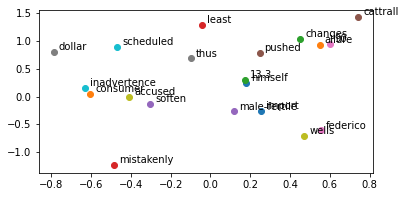

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### Skipgram


In [107]:
#delete dupliAthense word define as vocabs, also include unknow as <UNK>.
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenised)))
vocabs.append('<UNK>') # to let '<UNK>' become the last.
word2index = {v: idx+1 for idx, v in enumerate(vocabs)} #plus one to shift value in word index to assign <UNK>'s value to 0 without dupliAthension with others.
word2index['<UNK>'] = 0

In [108]:
# Create index to word
index2word = {v:k for k, v in word2index.items()}

index2word[50]

'laughs'

### 2. Prepare train data

In [109]:
skipgrams = []

#for each corpus
for sent in corpus_tokenised:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(2, len(sent) - 2): # start from 1 to second last but we use window size of 2, then first centre word should be at index 2
        center_word = sent[i]
        outside_words = np.ravel([sent[i - 2:i],sent[i+1: i + 3]])  # window_size = 2
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams[:50] #shows only sample 50 elements

[['oct.', 'in'],
 ['oct.', 'an'],
 ['oct.', '19'],
 ['oct.', 'review'],
 ['19', 'an'],
 ['19', 'oct.'],
 ['19', 'review'],
 ['19', 'of'],
 ['review', 'oct.'],
 ['review', '19'],
 ['review', 'of'],
 ['review', '``'],
 ['of', '19'],
 ['of', 'review'],
 ['of', '``'],
 ['of', 'the'],
 ['``', 'review'],
 ['``', 'of'],
 ['``', 'the'],
 ['``', 'misanthrope'],
 ['the', 'of'],
 ['the', '``'],
 ['the', 'misanthrope'],
 ['the', "''"],
 ['misanthrope', '``'],
 ['misanthrope', 'the'],
 ['misanthrope', "''"],
 ['misanthrope', 'at'],
 ["''", 'the'],
 ["''", 'misanthrope'],
 ["''", 'at'],
 ["''", 'chicago'],
 ['at', 'misanthrope'],
 ['at', "''"],
 ['at', 'chicago'],
 ['at', "'s"],
 ['chicago', "''"],
 ['chicago', 'at'],
 ['chicago', "'s"],
 ['chicago', 'goodman'],
 ["'s", 'at'],
 ["'s", 'chicago'],
 ["'s", 'goodman'],
 ["'s", 'theatre'],
 ['goodman', 'chicago'],
 ['goodman', "'s"],
 ['goodman', 'theatre'],
 ['goodman', '-lrb-'],
 ['theatre', "'s"],
 ['theatre', 'goodman']]

In [110]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    for sent in corpus:
        for i in range(2, len(sent) - 2): #start from 2 to third last for window size = 2
            centre_word = word2index[sent[i]]
            outside_words = []
            for j in np.ravel([sent[i - 2:i],sent[i + 1: i + 3]]):
                outside_words.append(word2index[j])  #window_size = 2
            for o in outside_words:
                skipgrams.append([centre_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [111]:
input, label = random_batch(10, corpus_tokenised)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[4023],
       [4497],
       [3591],
       [  19],
       [3500],
       [1058],
       [2827],
       [4646],
       [ 502],
       [4310]])


### 3. Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [112]:
from collections import Counter

word_count = Counter(flatten(corpus_tokenised))
# word_count # Showing word count

In [113]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

24358

In [114]:
z = 0.001  #scaling up low frequency terms
unigram_table = []

# create loop for the P(w) formula
for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** (3/4)
    uw_alpha_dividebyz = int(uw_alpha / z)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
# Counter(unigram_table)

### 4. Negative sampling

In [115]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [116]:
import random

def negative_sampling(targets, unigram_table, k):
    
    batch_size = targets.shape[0]
    neg_samples = []
    
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)

In [117]:
batch_size = 2
input_batch, label_batch = random_batch(batch_size, corpus_tokenised)

input_batch, label_batch

(array([[3250],
        [3250]]),
 array([[502],
        [ 96]]))

In [118]:
# Convert to Tensor

input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch)

In [119]:
num_neg = 10  # I will try 10 as in the paper.
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)

In [120]:
neg_samples.shape # shape is (batch_size, num_neg)

torch.Size([2, 10])

### 5. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [121]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_centre_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, centre_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        centre_embed  = self.embedding_centre_word(centre_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(centre_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(centre_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()

In [122]:
input, label = random_batch(batch_size, corpus_tokenised)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [123]:
emb_size = 10 # I will try on 10.
voc_size = len(vocabs)
modelSkNeg = SkipgramNeg(voc_size, emb_size)

In [124]:
neg_tensor = negative_sampling(label_tensor, unigram_table, 5)

In [125]:
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [126]:
loss = modelSkNeg(input_tensor, label_tensor, neg_tensor)
loss

tensor(2.1989, grad_fn=<NegBackward0>)

### 4. Training

In [127]:
voc_size   = len(vocabs)
batch_size = 2
emb_size   = 10
modelSkNeg      = SkipgramNeg(voc_size, emb_size)

optimizer  = optim.Adam(modelSkNeg.parameters(), lr=0.001)

In [128]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [129]:
num_epochs = 500
startp = time.time()
for epoch in range(num_epochs):

    #get random batch
    start = time.time()
    input_batch, label_batch = random_batch(batch_size, corpus_tokenised)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, 5)    
    
    #loss = modelSkNeg
    loss = modelSkNeg(input_batch, label_batch, neg_batch)
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {epoch_mins}m {epoch_secs}s")
endp = time.time()
mins, secs = epoch_time(startp, endp)
print(f"Process Time: {mins}m {secs}s")

Epoch 100 | Loss: 0.357088 | Time: 0m 0s
Epoch 200 | Loss: 1.945285 | Time: 0m 0s
Epoch 300 | Loss: 2.073411 | Time: 0m 0s
Epoch 400 | Loss: 0.889838 | Time: 0m 0s
Epoch 500 | Loss: 4.167721 | Time: 0m 0s
Process Time: 3m 6s


### 5. Plot the embeddings

In [130]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = modelSkNeg.embedding_centre_word(word)
    outside_embed = modelSkNeg.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [131]:
print(get_embed('Athens'))

(-0.447147399187088, 0.7554438710212708)


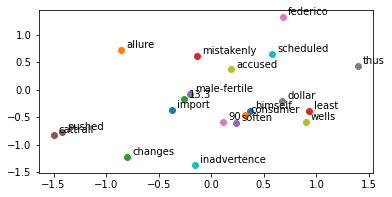

In [132]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 4. Do some testing, compare 2-3 sentences with spaCy and see whether our neural network gives the same dependency.

In [133]:
train_set, dev_set, test_set = load_data()

sentence = [sent for sent in test_set]
sentences = [sentence[1], sentence[2], sentence[3]]

1. Loading data...
Example 1:  {'word': ['ms.', 'haag', 'plays', 'elianti', '.'], 'pos': ['NNP', 'NNP', 'VBZ', 'NNP', '.'], 'head': [2, 3, 0, 3, 3], 'dep': ['compound', 'nsubj', 'root', 'dobj', 'punct']}
took 2.49 seconds


In [134]:
for s in sentences:
    print(s['word'])

['but', 'while', 'the', 'new', 'york', 'stock', 'exchange', 'did', "n't", 'fall', 'apart', 'friday', 'as', 'the', 'dow', 'jones', 'industrial', 'average', 'plunged', '190.58', 'points', '--', 'most', 'of', 'it', 'in', 'the', 'final', 'hour', '--', 'it', 'barely', 'managed', 'to', 'stay', 'this', 'side', 'of', 'chaos', '.']
['some', '``', 'circuit', 'breakers', "''", 'installed', 'after', 'the', 'october', '1987', 'crash', 'failed', 'their', 'first', 'test', ',', 'traders', 'say', ',', 'unable', 'to', 'cool', 'the', 'selling', 'panic', 'in', 'both', 'stocks', 'and', 'futures', '.']
['the', '49', 'stock', 'specialist', 'firms', 'on', 'the', 'big', 'board', 'floor', '--', 'the', 'buyers', 'and', 'sellers', 'of', 'last', 'resort', 'who', 'were', 'criticized', 'after', 'the', '1987', 'crash', '--', 'once', 'again', 'could', "n't", 'handle', 'the', 'selling', 'pressure', '.']


In [135]:
# Now, Numericalize its!
sentences_n = parser.numericalize(sentences)

#### SpaCy

In [136]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

for s in sentences:
    doc = nlp(s['word'][0])
    options = {"collapse_punct": False}
    displacy.render(doc, options = options, style="dep", jupyter=True)

## Our model

### Prepare model

In [137]:
# Load model
model = ParserModel(embeddings_matrix)
model.eval()

ParserModel(
  (pretrained_embeddings): Embedding(5157, 50)
  (embed_to_hidden): Linear(in_features=1500, out_features=400, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_to_logits): Linear(in_features=400, out_features=3, bias=True)
)

Test

In [139]:
print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(sentences)

Restoring the best model weights found on the dev set


FileNotFoundError: [Errno 2] No such file or directory: 'output/20230202_162112/model.weights'

In [140]:
dependency

NameError: name 'dependency' is not defined